# Bayesian Parametric Survival Analysis with PyMC3

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from statsmodels import datasets
from theano import shared, tensor as tt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


## The Model

I'm using the exact same dataset and model structure as in the [tutorial](https://docs.pymc.io/notebooks/bayes_param_survival_pymc3.html#Bayesian-Parametric-Survival-Analysis-with-PyMC3).

In [2]:
sns.set()
blue, green, red, purple, gold, teal = sns.color_palette(n_colors=6)

pct_formatter = StrMethodFormatter('{x:.1%}')

In [3]:
df = (datasets.get_rdataset('mastectomy', 'HSAUR', cache=True)
              .data
              .assign(metastized=lambda df: 1. * (df.metastized == "yes"),
                      event=lambda df: 1. * df.event))

In [4]:
n_patient, _ = df.shape

X = np.empty((n_patient, 2))
X[:, 0] = 1.
X[:, 1] = df.metastized
X_ = shared(X)

y = np.log(df.time.values)
y_std = (y - y.mean()) / y.std()
cens = df.event.values == 0.
cens_ = shared(cens)

In [5]:
VAGUE_PRIOR_SD = 5.

In [6]:
def gumbel_sf(y, μ, σ):
    return 1. - tt.exp(-tt.exp(-(y - μ) / σ))

In [7]:
with pm.Model() as weibull_model:
    β = pm.Normal('β', 0., VAGUE_PRIOR_SD, shape=2)
    η = β.dot(X_.T)
    s = pm.HalfNormal('s', 5.)
    y_obs = pm.Gumbel('y_obs', η[~cens_], s, observed=y_std[~cens])
    y_cens = pm.Potential('y_cens', gumbel_sf(y_std[cens], η[cens_], s))

C:\Users\stuart.lacy\.conda\envs\pymcpy36\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\stuart.lacy\.conda\envs\pymcpy36\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


We now sample from the model.

In [8]:
SEED = 845199 # from random.org, for reproducibility

SAMPLE_KWARGS = {
    'chains': 3,
    'tune': 1000,
    'random_seed': [
        SEED,
        SEED + 1,
        SEED + 2
    ]
}

In [9]:
with weibull_model:
    weibull_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\stuart.lacy\.conda\envs\pymcpy36\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [s, β]
Sampling 3 chains: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:07<00:00, 624.93draws/s]


The Gelman-Rubin statistics also indicate convergence.

In [10]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(weibull_trace).values())

1.0077986339194245

# Predicting survival curves for new patients

I'm going to look at 3 methods for predicting the survival curve for a new patient, i.e. $S(t | x^*)$, in particular for one patient with metastized disease and one without.

## Sampling T

In the [original notebook](https://docs.pymc.io/notebooks/bayes_param_survival_pymc3.html#Bayesian-Parametric-Survival-Analysis-with-PyMC3) the method for calculating S(t) relies upon sampling the event times $T$ from the posterior predictive distribution, and at each timepoint of interest $t_{i}, i \in 1, \dots, N$, seeing what proportion of samples are alive, i.e. $T > t_{i}$.

The `shared` input values are updated and then samples are drawn.

In [11]:
t_plot = np.linspace(0, 230, 100)

In [12]:
X_pp = np.empty((2, 2))
X_pp[:, 0] = 1.
X_pp[:, 1] = [0, 1]
X_.set_value(X_pp)

cens_pp = np.repeat(False, 2)
cens_.set_value(cens_pp)

In [13]:
with weibull_model:
    pp_weibull_trace = pm.sample_posterior_predictive(
        weibull_trace, samples=1500, vars=[y_obs]
    )

  0%|                                                                                                                              | 0/1500 [00:00<?, ?it/s]C:\Users\stuart.lacy\.conda\envs\pymcpy36\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 2088.67it/s]


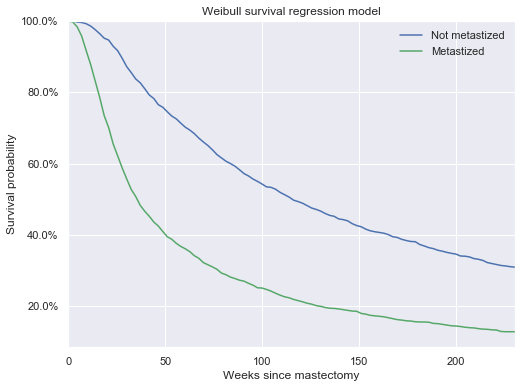

In [14]:
weibull_pp_surv = (np.greater_equal
                     .outer(np.exp(y.mean() + y.std() * pp_weibull_trace['y_obs']),
                            t_plot))
weibull_pp_surv_mean = weibull_pp_surv.mean(axis=0)
fig, ax = plt.subplots(figsize=(8, 6))


ax.plot(t_plot, weibull_pp_surv_mean[0],
        c=blue, label="Not metastized");
ax.plot(t_plot, weibull_pp_surv_mean[1],
        c=red, label="Metastized");

ax.set_xlim(0, 230);
ax.set_xlabel("Weeks since mastectomy");

ax.set_ylim(top=1);
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Survival probability");

ax.legend(loc=1);
ax.set_title("Weibull survival regression model");

## Manually calculating S(t) from posterior predictive

Since $T = \eta + \epsilon$ and $\epsilon \sim \text{Gumbel}(0, s)$, then $T \sim \text{Gumbel}(\eta, s)$, and so $S(t) = 1 - F_{\text{Gumbel}}(t)$.
We can sample $s$ directly from the posterior predictive and $\eta$ is simply the linear predictor, which can be calculated from our new data points and the sampled coefficients $\beta$.

This produces a slightly different curve than the previous method, this could be due to the number of samples that were taken, or are these two methods calculating different quantities?

Of course with manually calculating $S(t)$ from the coefficients we can obtain 95% CI, while I cannot see how to do this for the method above.

In [15]:
# Recreate CDF in numpy
def gumbel_sf_np(y, μ, σ):
    return 1. - np.exp(-np.exp(-(y - μ) / σ))

In [16]:
with weibull_model:
   ppc2 = pm.sample_posterior_predictive(
        weibull_trace, samples=1500, vars=[s, β]
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 42424.99it/s]


In [17]:
eta_ = ppc2['β'].dot(X_pp.T)
eta_.shape

(1500, 2)

In [18]:
# modelled standardised log times
t_plot_std = np.log(t_plot[1:])  # Log(0) = -Inf
t_plot_std = (t_plot_std - t_plot_std.mean()) / t_plot_std.std()

# Not familiar enough with numpy to vectorise this...
probs = np.empty((1500, 2, t_plot_std.size))
for i in range(1500):
    for j in range(2):
        for t in range(t_plot_std.size):
            probs[i, j, t] = gumbel_sf_np(t_plot_std[t], eta_[i, j], ppc2['s'][i])

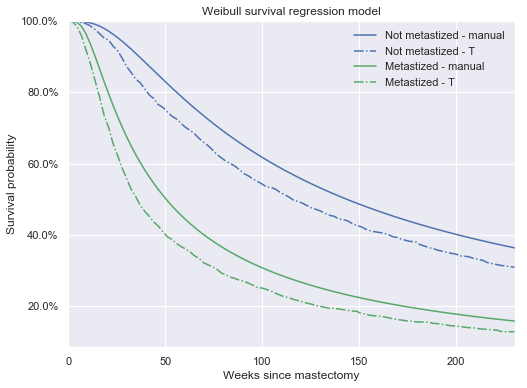

In [19]:
pp_surv2 = probs.mean(axis=0)
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(t_plot, np.insert(pp_surv2[0], 0, 1),
        c=blue, label="Not metastized - manual");
ax.plot(t_plot, weibull_pp_surv_mean[0],
        c=blue, label="Not metastized - T", linestyle='-.');
ax.plot(t_plot, np.insert(pp_surv2[1], 0, 1),
        c=red, label="Metastized - manual");
ax.plot(t_plot, weibull_pp_surv_mean[1],
        c=red, label="Metastized - T", linestyle='-.');

ax.set_xlim(0, 230);
ax.set_xlabel("Weeks since mastectomy");

ax.set_ylim(top=1);
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Survival probability");

ax.legend(loc=1);
ax.set_title("Weibull survival regression model");

## Manually calculating S(t) from posterior

Finally, what happens if I use the coefficients $\beta$ and $s$ taken from the posterior distribution instead? I.e. those values directly from the trace.
It seems to produce identical values of $S(t)$, as they appear to be overlapping on the plot.
Directly comparing the arrays below shows they are identical, and furthermore the $s$ from the posterior and from the posterior predictive are identical.

**Why are these two traces the same?**
**What is the correct way to estimate survival curves for new patients?**

In [20]:
eta2_ = weibull_trace['β'].dot(X_pp.T)
eta2_.shape

(1500, 2)

In [21]:
probs2 = np.empty((1500, 2, t_plot_std.size))
for i in range(1500):
    for j in range(2):
        for t in range(t_plot_std.size):
            probs2[i, j, t] = gumbel_sf_np(t_plot_std[t], eta2_[i, j], weibull_trace['s'][i])

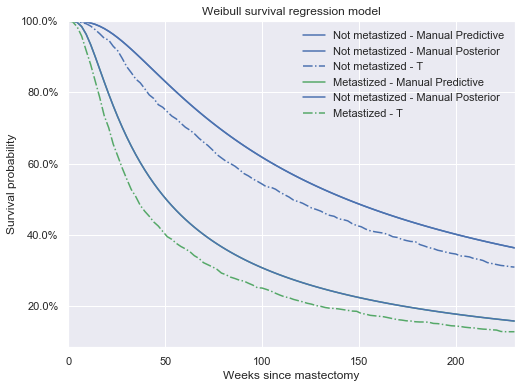

In [22]:
pp_surv3 = probs2.mean(axis=0)
fig, ax = plt.subplots(figsize=(8, 6))


ax.plot(t_plot, np.insert(pp_surv2[0], 0, 1),
        c=blue, label="Not metastized - Manual Predictive");
ax.plot(t_plot, np.insert(pp_surv3[0], 0, 1),
        c=blue, label="Not metastized - Manual Posterior", linestyle='-');
ax.plot(t_plot, weibull_pp_surv_mean[0],
        c=blue, label="Not metastized - T", linestyle='-.');

ax.plot(t_plot, np.insert(pp_surv2[1], 0, 1),
        c=red, label="Metastized - Manual Predictive");
ax.plot(t_plot, np.insert(pp_surv3[1], 0, 1),
        c=blue, label="Not metastized - Manual Posterior", linestyle='-');
ax.plot(t_plot, weibull_pp_surv_mean[1],
        c=red, label="Metastized - T", linestyle='-.');

ax.set_xlim(0, 230);
ax.set_xlabel("Weeks since mastectomy");

ax.set_ylim(top=1);
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Survival probability");

ax.legend(loc=1);
ax.set_title("Weibull survival regression model");

In [23]:
np.all(pp_surv2[0] == pp_surv3[0])

True

In [24]:
np.all(pp_surv2[1] == pp_surv3[1])

True

In [25]:
np.all(weibull_trace['s'] == ppc2['s'])

True

## Authors

- Originally authored as a blog post by [Austin Rochford](https://austinrochford.com/posts/2017-10-02-bayes-param-survival.html) on October 2, 2017.
- Updated by [George Ho](https://eigenfoo.xyz/) on July 18, 2018.